<a href="https://www.kaggle.com/code/mustafakapici/sirtuin6-molecules-classification?scriptVersionId=182912318" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Hello buddy, Comments are Welcomed, if you have suggestions & questions ? Please add them in discussion section, happy to have conversion with you, Cheers!

![thanks](https://i.imgflip.com/8ngeel.jpg)

# Import data and package stuff (☞ﾟヮﾟ)☞

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna, warnings, random
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

plt.style.use('dark_background')
warnings.simplefilter('ignore', category=FutureWarning)

In [2]:
path='/kaggle/input/sirtuin6-small-molecules-dataset/SIRTUIN6.csv'

df = pd.read_csv(path)

df

,SC-5,SP-6,SHBd,minHaaCH,maxwHBa,FMF,Class
0,0.540936,7.64192,0.162171,0.445270,2.205570,0.467742,High_BFE
1,0.815332,6.59011,0.000000,0.497445,2.003140,0.415385,High_BFE
2,0.734399,6.85522,0.000000,0.507748,1.885900,0.400000,High_BFE
3,0.624557,7.00949,0.450300,0.483648,2.027570,0.500000,High_BFE
4,0.460290,4.92643,0.448998,0.482293,2.064380,0.536585,High_BFE
...,...,...,...,...,...,...,...
95,0.083333,3.50569,0.000000,0.438522,2.221560,0.307692,Low_BFE
96,0.707068,4.58381,0.000000,0.000000,0.011251,0.153846,Low_BFE
97,0.216506,3.09490,0.000000,0.000000,0.000000,0.326531,Low_BFE
98,0.271018,2.39997,0.000000,0.356727,2.346090,0.342105,Low_BFE


In [3]:
#drop unnecessary columns
#df.drop(columns=['unnecessary'], inplace=True)

# Data Insights 🧐

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SC-5      100 non-null    float64
 1   SP-6      100 non-null    float64
 2   SHBd      100 non-null    float64
 3   minHaaCH  100 non-null    float64
 4   maxwHBa   100 non-null    float64
 5   FMF       100 non-null    float64
 6   Class     100 non-null    object 
dtypes: float64(6), object(1)
memory usage: 5.6+ KB


In [5]:
pd.DataFrame(df.isna().sum()).T.style.background_gradient(cmap='rainbow')

,SC-5,SP-6,SHBd,minHaaCH,maxwHBa,FMF,Class
0,0,0,0,0,0,0,0


In [6]:
df.describe(percentiles=[0, .25, .30, .50, .75, .80, 1]).T.style.background_gradient(cmap = 'inferno')

,count,mean,std,min,0%,25%,30%,50%,75%,80%,100%,max
SC-5,100.000000,0.420488,0.195124,0.083333,0.083333,0.282118,0.297280,0.393350,0.532954,0.558706,0.918546,0.918546
SP-6,100.000000,4.429250,1.403348,2.091810,2.091810,3.345093,3.523134,4.107115,5.302952,5.564856,7.641920,7.641920
SHBd,100.000000,0.356504,0.339313,0.000000,0.000000,0.000000,0.000000,0.373387,0.482501,0.520692,1.465000,1.465000
minHaaCH,100.000000,0.443628,0.138964,0.000000,0.000000,0.429809,0.434647,0.467655,0.505934,0.512083,0.720723,0.720723
maxwHBa,100.000000,1.919511,0.522992,0.000000,0.000000,1.839850,1.889309,2.020210,2.161543,2.184678,3.778650,3.778650
FMF,100.000000,0.376232,0.072255,0.153846,0.153846,0.326531,0.337288,0.376024,0.423240,0.438877,0.536585,0.536585


In [7]:
target = 'Class'

cont_cols = df.select_dtypes('number').columns
cont_cols = cont_cols[cont_cols != target]

obj_cols = df.select_dtypes(object).columns


#other_categorics = ['feature1','feature2','feature3','feature4','feature5']

obj_cols = obj_cols.tolist() 


# Convert cont_cols to a list and remove any columns that are in obj_cols
cont_cols = cont_cols.tolist()
cont_cols = [col for col in cont_cols if col not in obj_cols]

len(cont_cols), len(obj_cols)
print(f'Object cols: {obj_cols}')
print(f'Continuous Cols: {cont_cols}')

Object cols: ['Class']
Continuous Cols: ['SC-5', 'SP-6', 'SHBd', 'minHaaCH', 'maxwHBa', 'FMF']


In [8]:
def mPlotter(r, c, size, _targets, text):
    
    bg = '#010108'
    
    palette = ['#df5337', '#d24644', '#f7d340', '#3339FF', '#440a68', '#84206b', '#f1ef75', '#fbbe23', '#400a67']
    
    font = 'Comic Sans MS'
    
    fig = plt.figure(figsize=size)
    
    fig.patch.set_facecolor(bg)
    
    grid = fig.add_gridspec(r, c)
    
    grid.update(wspace=0.5, hspace=0.25)
    
    __empty_diff = ((r * c) - 1) - len(_targets)
        
    axes = []
    
    for i in range(r):
        for j in range(c):
            axes.append(fig.add_subplot(grid[i, j]))
    
    for idx, ax in enumerate(axes):
        ax.set_facecolor(bg) 
        
        if idx == 0:
            ax.spines["bottom"].set_visible(False)
            ax.tick_params(left=False, bottom=False)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.text(0.5, 0.5,
                 f'{text}',
                 horizontalalignment='center',
                 verticalalignment='center',
                 fontsize=18, 
                 fontweight='bold',
                 fontfamily=font,
                 color="#fff")
        else:
            if (idx - 1) < len(_targets):
                ax.set_title(_targets[idx - 1].capitalize(), fontsize=14, fontweight='bold', fontfamily=font, color="#fff")
                ax.grid(color='#fff', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
                ax.set_xlabel("")
                ax.set_ylabel("")
            else:
                ax.spines["bottom"].set_visible(False)
                ax.tick_params(left=False, bottom=False)
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        
    def cb(ax):
        ax.set_xlabel("")
        ax.set_ylabel("")
        
    if __empty_diff > 0:
        axes = axes[:-1*__empty_diff]
        
    return axes, palette, cb

# Data Visualization 📊

![eda](https://i.imgflip.com/8o7sml.jpg)

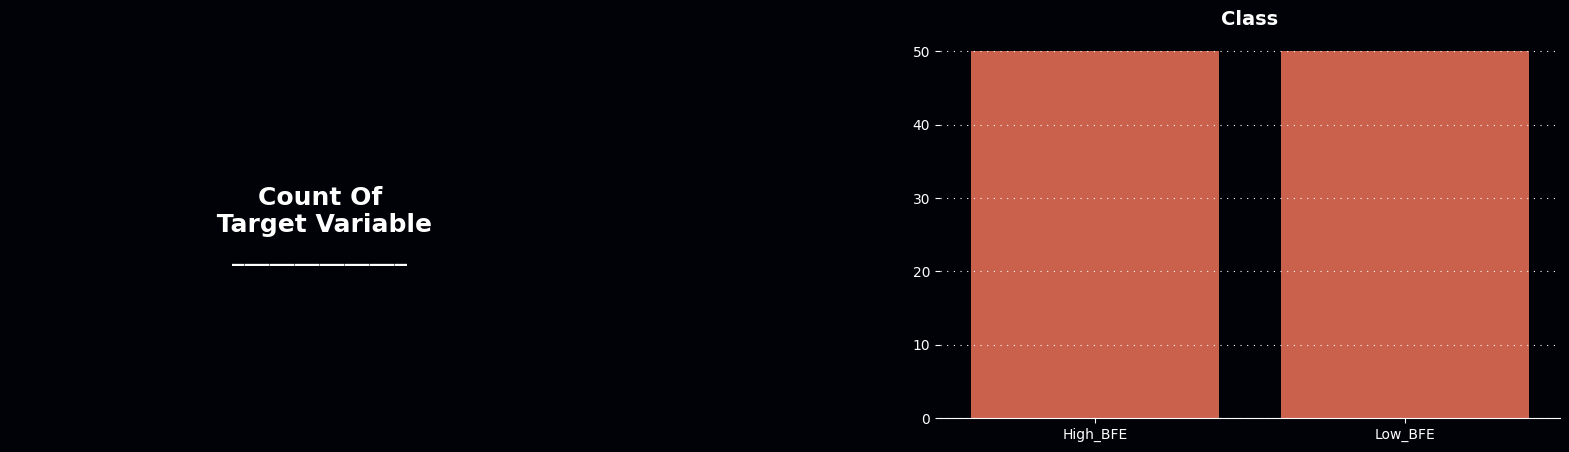

In [9]:
axes, palette, cb = mPlotter(1, 2, (20, 5), [target], 'Count Of\n Target Variable\n______________')

sns.countplot(x=df[target], ax = axes[1], color=palette[0])
cb(axes[1])

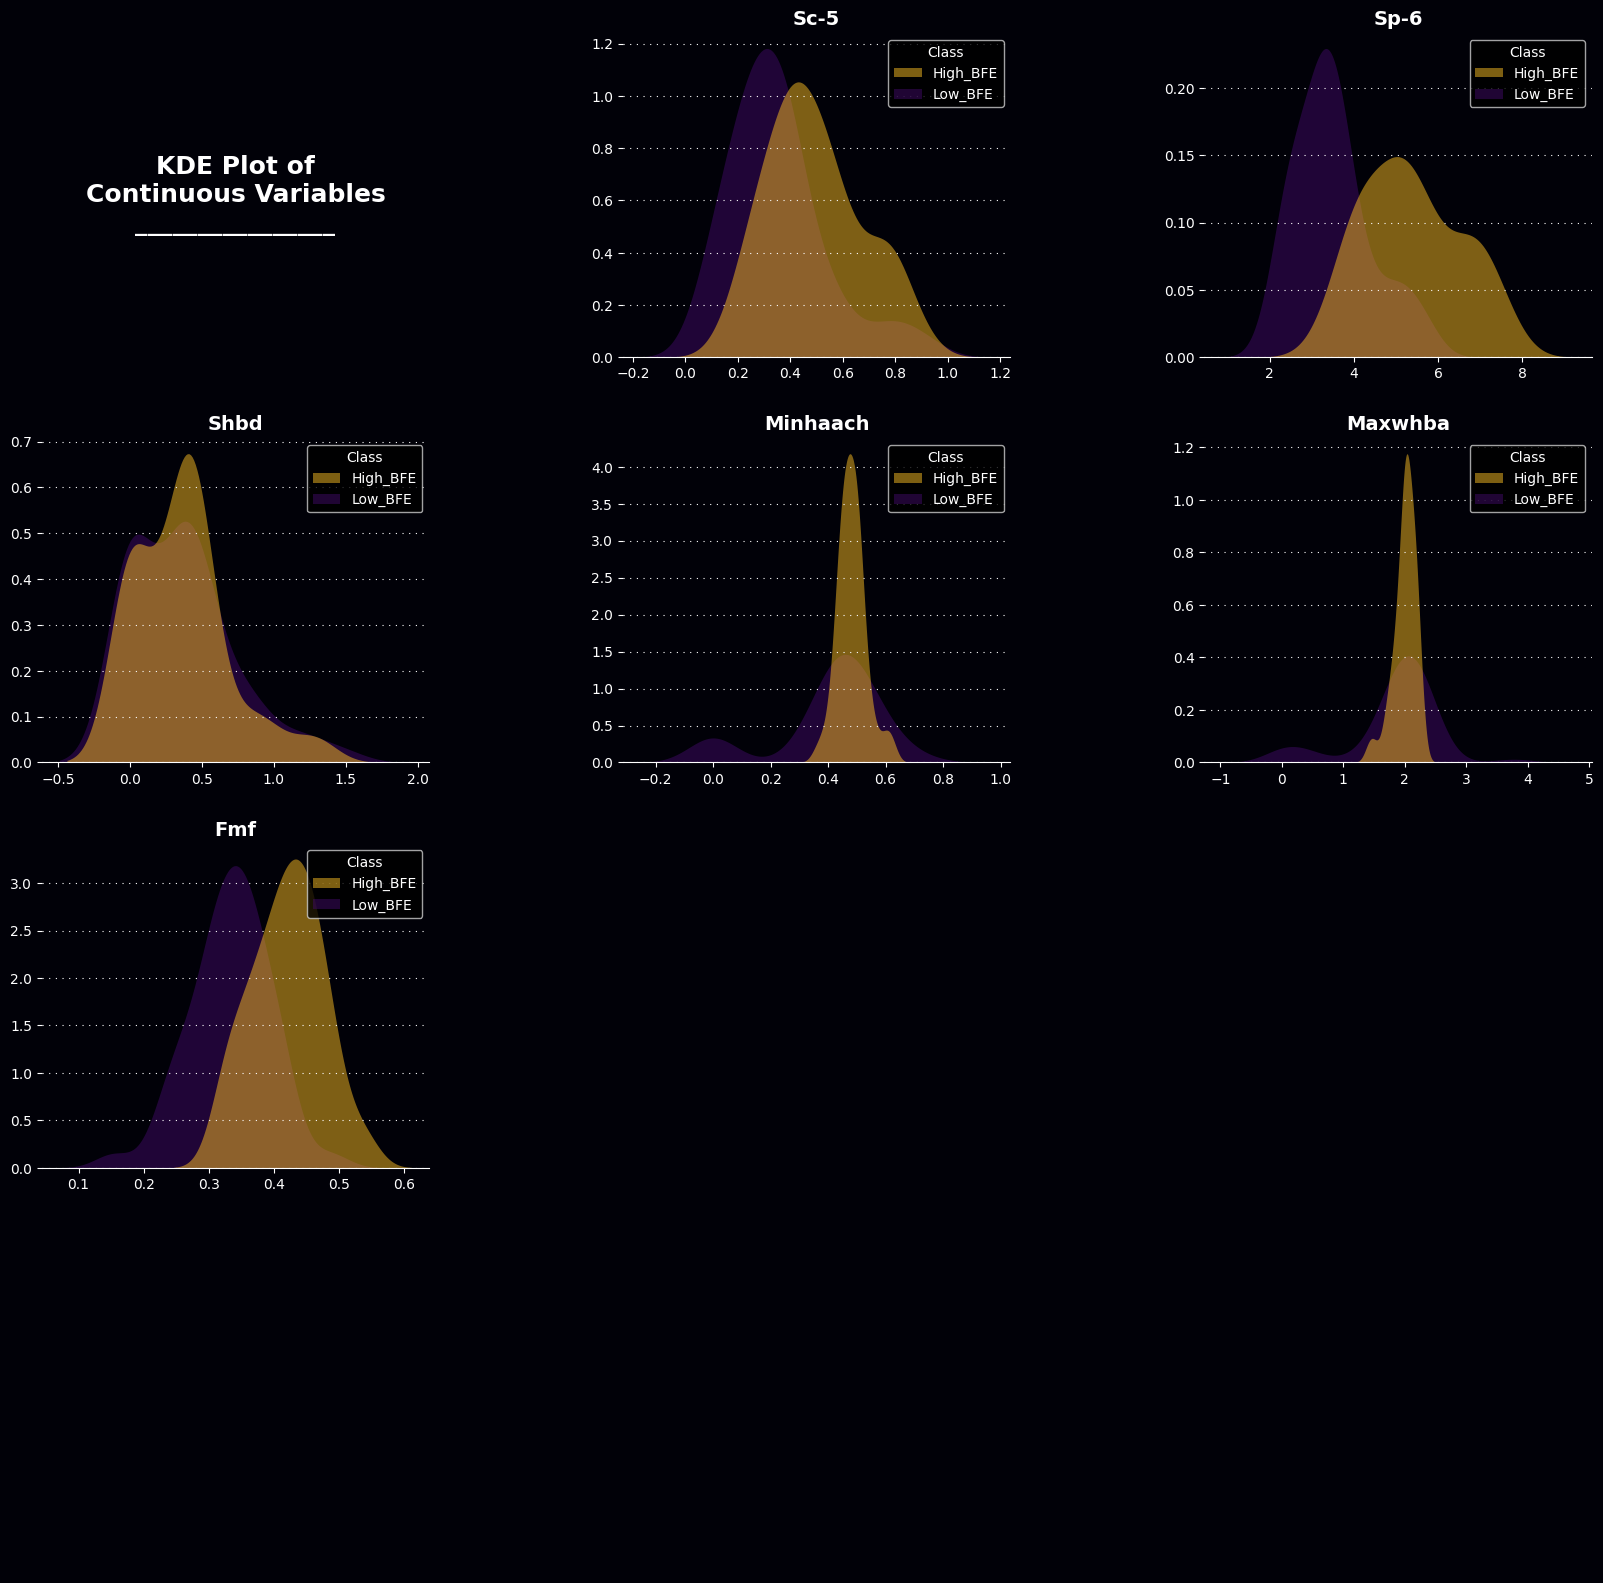

In [10]:
axes, palette, cb = mPlotter(4, 3, (20, 20), cont_cols, 'KDE Plot of\nContinuous Variables\n________________')

for col, ax in zip(cont_cols, axes[1:]):
    sns.kdeplot(data=df, x=col, ax=ax, hue=target, palette=palette[7:9], alpha=.5, linewidth=0, fill=True)
    cb(ax)

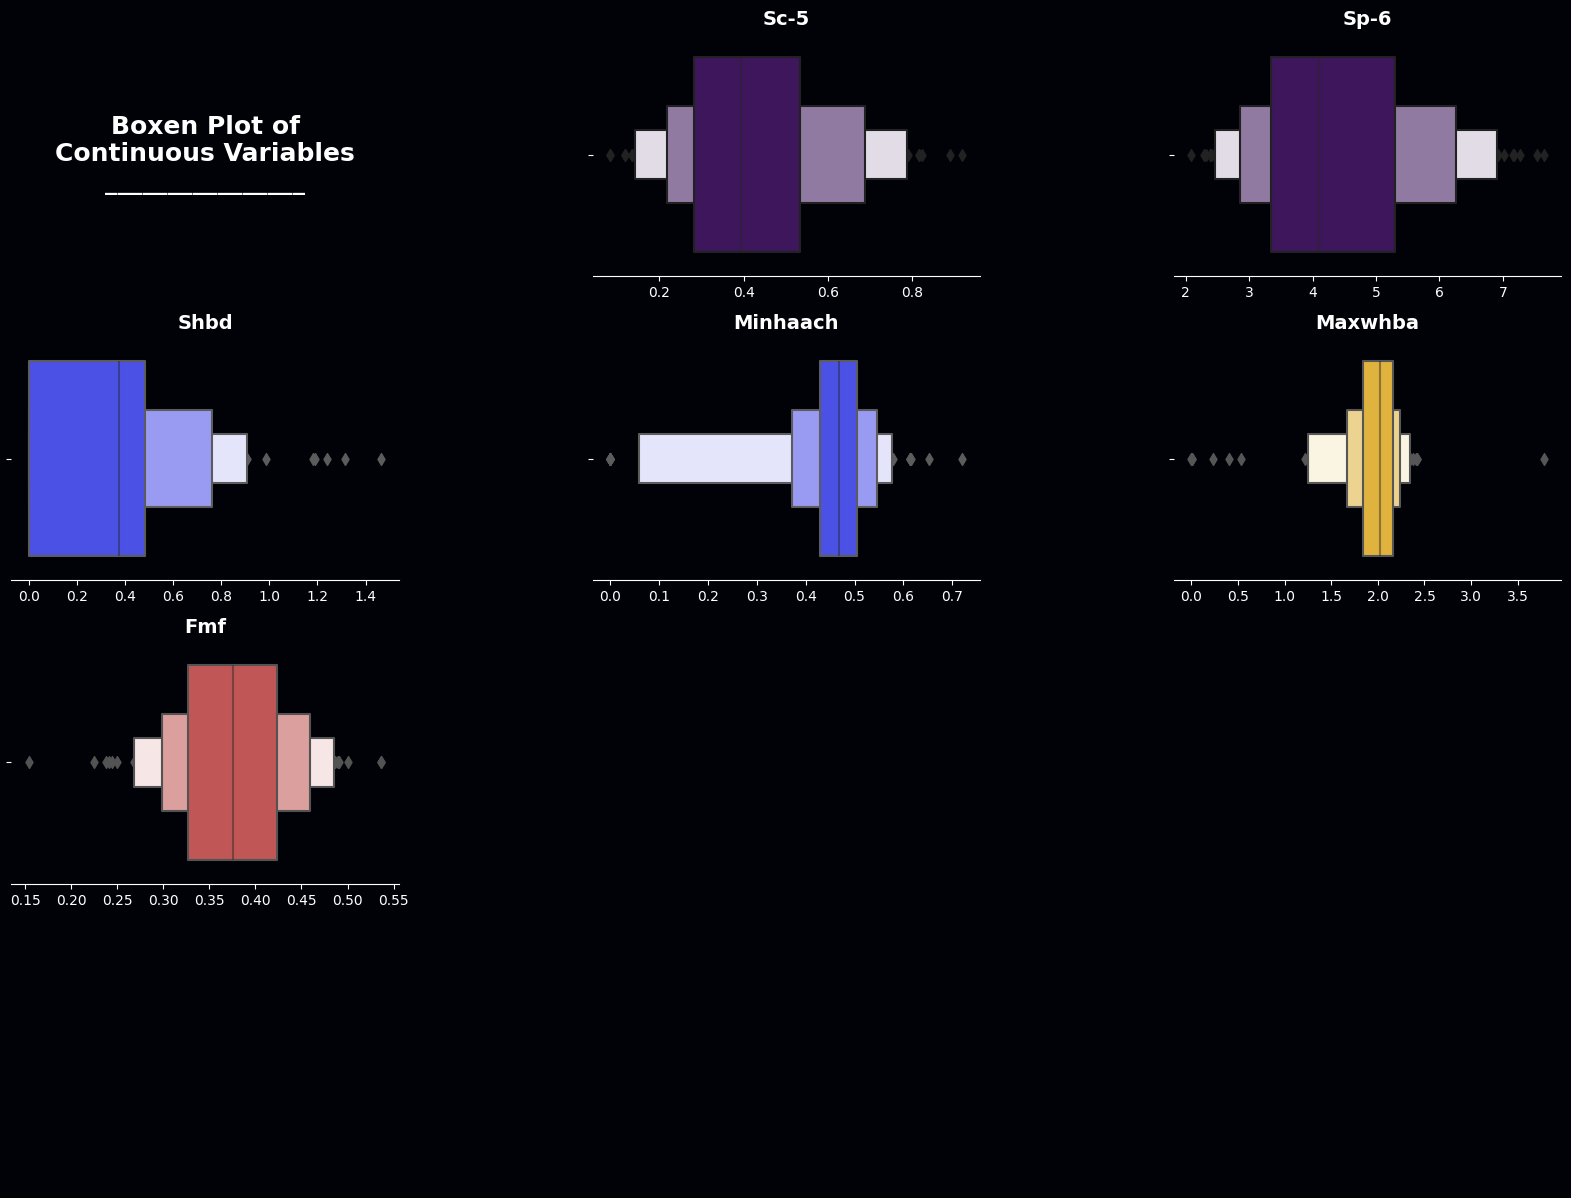

In [11]:
axes, palette, cb = mPlotter(4, 3, (20, 15), cont_cols, 'Boxen Plot of\nContinuous Variables\n________________')

for col, ax in zip(cont_cols, axes[1:]):
    sns.boxenplot(data=df, x=col, ax=ax, palette=[palette[random.randint(0, len(palette)-1)]])
    cb(ax)

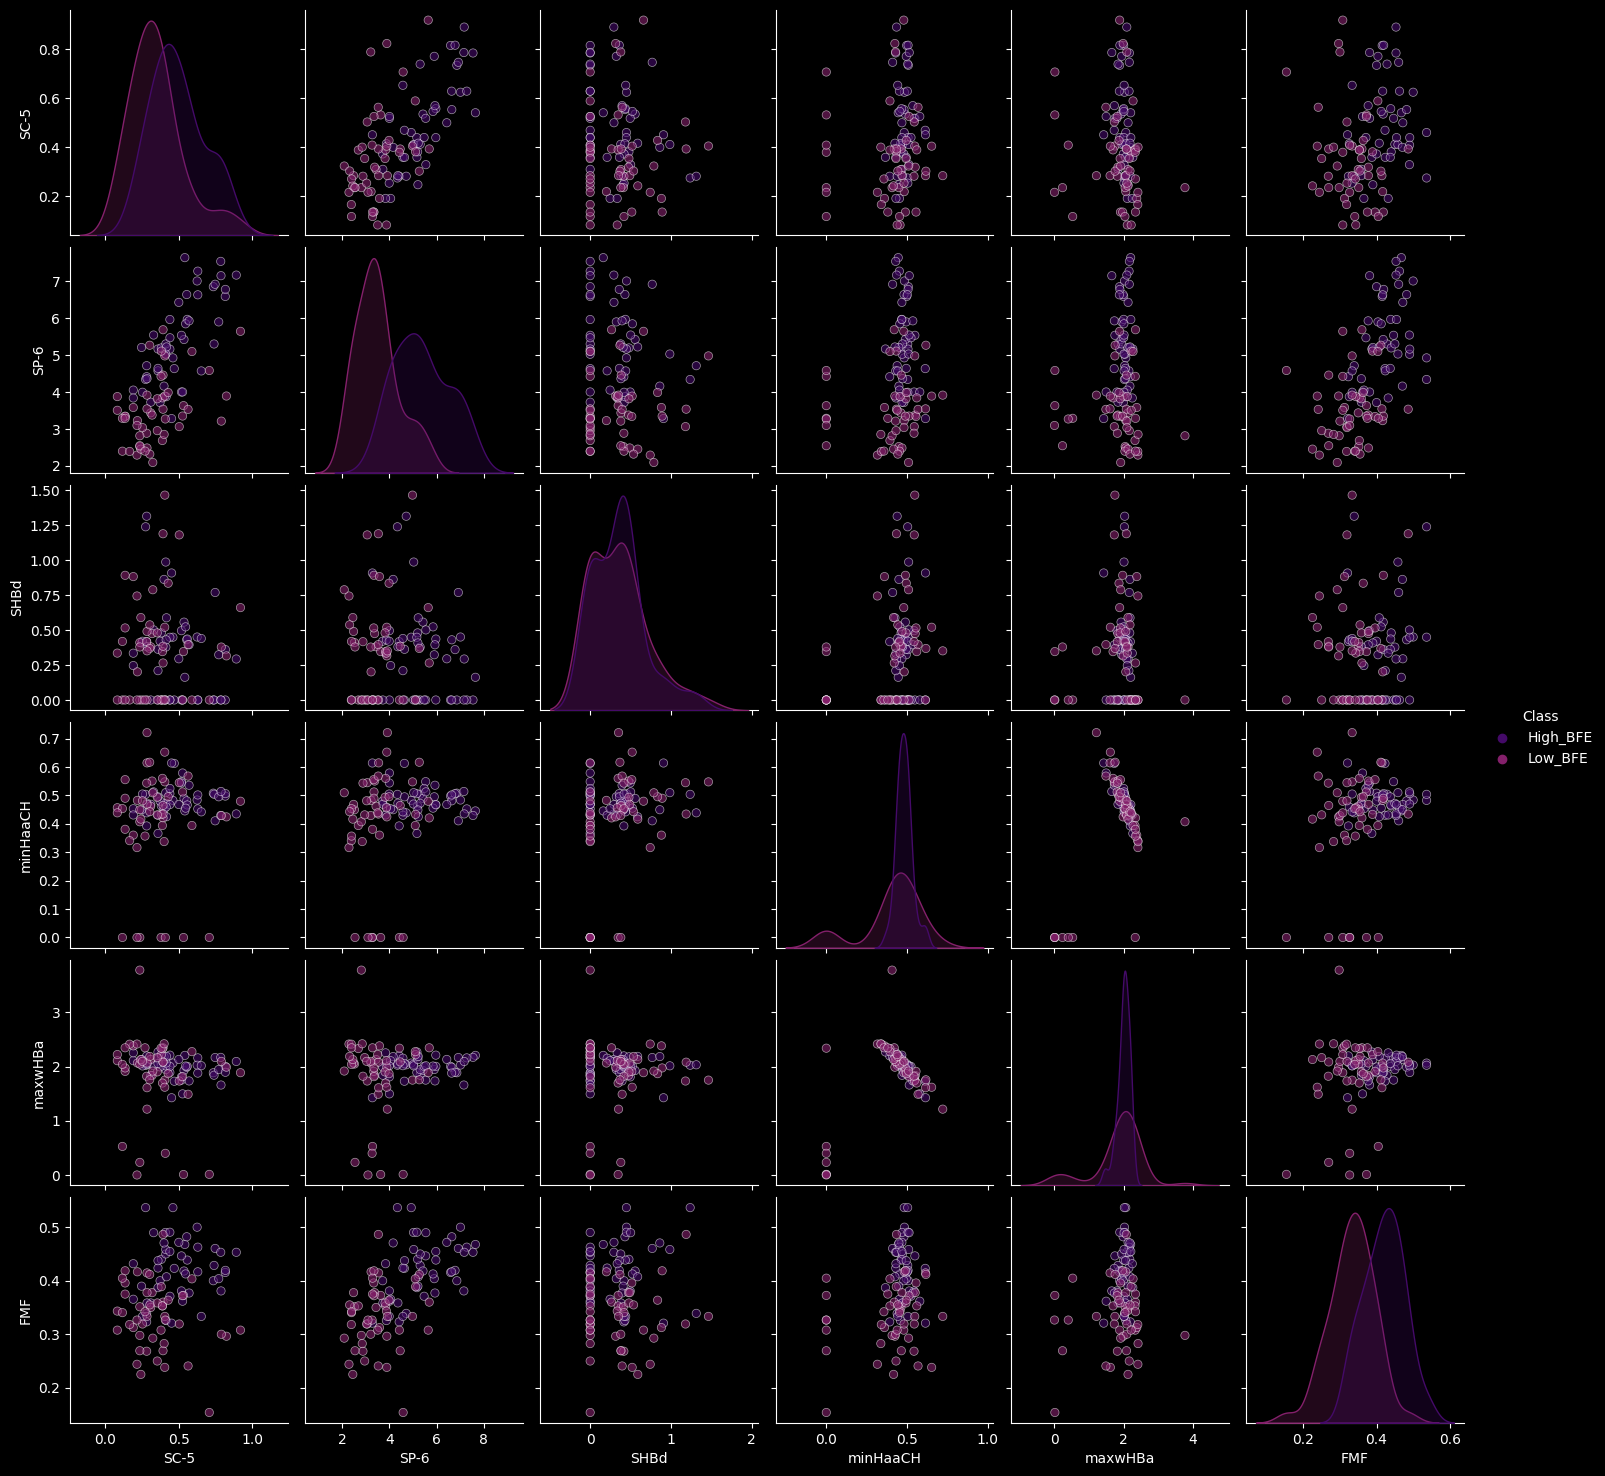

In [12]:
# pair plot
sns.pairplot(data=df, hue=target, palette=palette[4:6], diag_kind='kde', plot_kws={'alpha':.6})

In [13]:
ax = px.scatter_3d(df, x="SC-5", y="SP-6", z="SHBd", template= "plotly_dark", color=target, title="3D Scatter Plot of Continuous Variables")

ax.show()

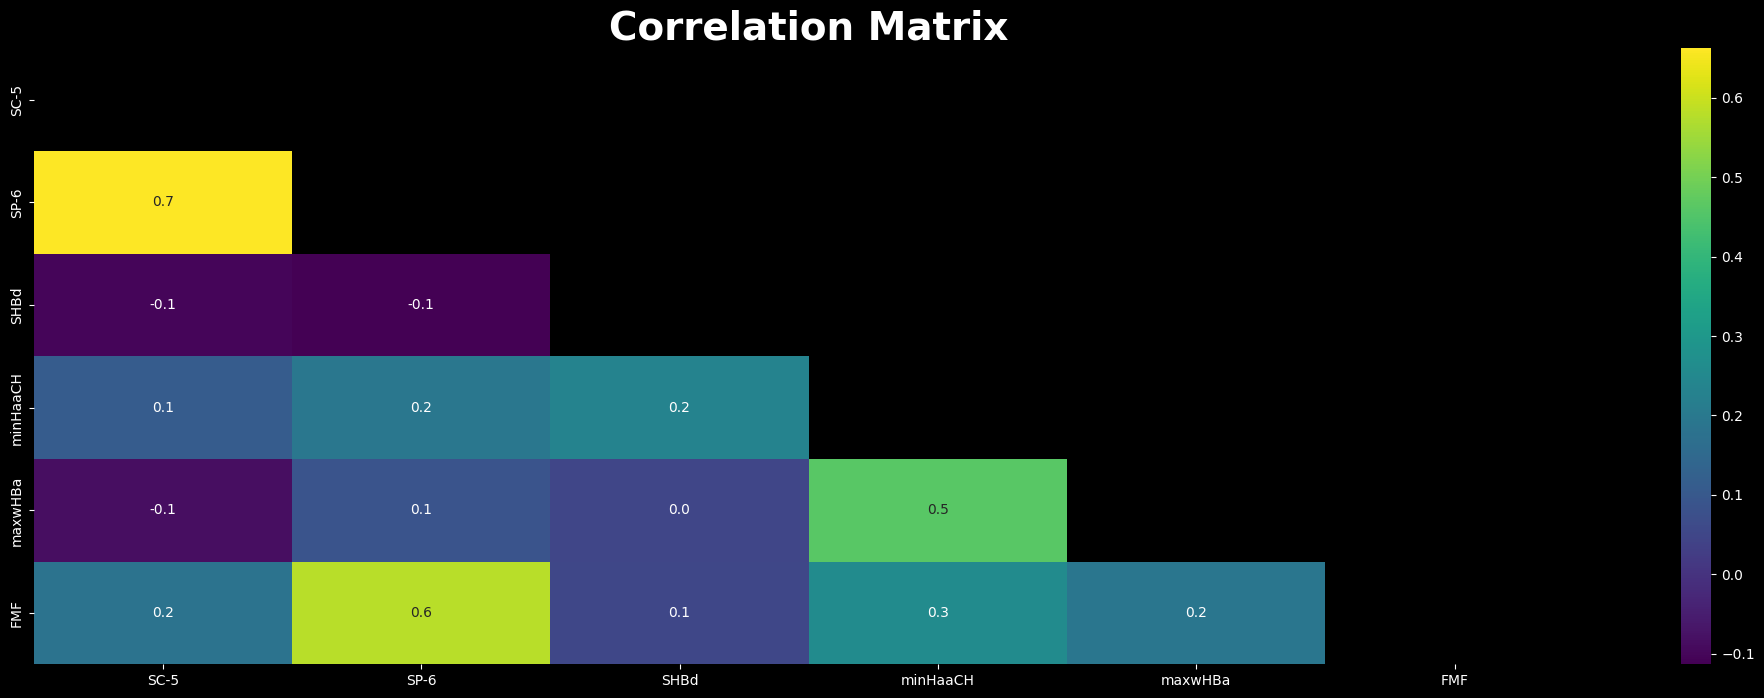

In [14]:
fig = plt.figure(figsize=(25, 8))

gs = fig.add_gridspec(1, 1)

gs.update(wspace=0.3, hspace=0.15)

ax = fig.add_subplot(gs[0, 0])

ax.set_title("Correlation Matrix", fontsize=28, fontweight='bold', fontfamily='Comic Sans MS', color="#fff")

sns.heatmap(df[cont_cols].corr().transpose(), mask=np.triu(np.ones_like(df[cont_cols].corr().transpose())), fmt=".1f", annot=True, cmap='viridis')

plt.show()

In [15]:
for col in df.select_dtypes(object):
    df[col] = LabelEncoder().fit_transform(df[col])
    
df

,SC-5,SP-6,SHBd,minHaaCH,maxwHBa,FMF,Class
0,0.540936,7.64192,0.162171,0.445270,2.205570,0.467742,0
1,0.815332,6.59011,0.000000,0.497445,2.003140,0.415385,0
2,0.734399,6.85522,0.000000,0.507748,1.885900,0.400000,0
3,0.624557,7.00949,0.450300,0.483648,2.027570,0.500000,0
4,0.460290,4.92643,0.448998,0.482293,2.064380,0.536585,0
...,...,...,...,...,...,...,...
95,0.083333,3.50569,0.000000,0.438522,2.221560,0.307692,1
96,0.707068,4.58381,0.000000,0.000000,0.011251,0.153846,1
97,0.216506,3.09490,0.000000,0.000000,0.000000,0.326531,1
98,0.271018,2.39997,0.000000,0.356727,2.346090,0.342105,1


# Split the cakes equal 🍰

In [16]:
le = LabelEncoder()
df[target] = le.fit_transform(df[target])


In [17]:
X = df.drop(columns=[target], axis=1)
y = df[target].values

In [18]:
X.head()

,SC-5,SP-6,SHBd,minHaaCH,maxwHBa,FMF
0,0.540936,7.64192,0.162171,0.445270,2.20557,0.467742
1,0.815332,6.59011,0.000000,0.497445,2.00314,0.415385
2,0.734399,6.85522,0.000000,0.507748,1.88590,0.400000
3,0.624557,7.00949,0.450300,0.483648,2.02757,0.500000
4,0.460290,4.92643,0.448998,0.482293,2.06438,0.536585


In [19]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70, 6), (30, 6), (70,), (30,))

# Scale the data to ground 🌄

In [21]:
X_train = MinMaxScaler().fit_transform(X_train)
X_test = MinMaxScaler().fit_transform(X_test)

# The Black Magic 🧿

![model](https://i.imgflip.com/8o7ssy.jpg)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
    #'XGBoost': XGBClassifier(),
    #'CatBoost': CatBoostClassifier(verbose=0),
    'KNN': KNeighborsClassifier(),
    #'Neural Network': MLPClassifier(),
    #'LGBM': LGBMClassifier(),
    'Voting Classifier': VotingClassifier(
        estimators=[
            ('cat', CatBoostClassifier(verbose=0)), 
            ('xg', XGBClassifier()), 
            ('lgbm', LGBMClassifier(verbose=-1))],
    voting='soft',
    verbose=False
)
}


params={
    'Logistic Regression': {'C': [0.1, 1, 10, 100], 'solver': ['liblinear'], 'max_iter': [200]},
    'Decision Tree': {'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, 7, 9, 11, 13]},
    'Random Forest': {'n_estimators': [100, 300, 500], 'max_depth': [3, 5, 7, 9, 11, 13]},
    'KNN': {'n_neighbors': [3, 5, 7, 9 , 13], 'weights': ['uniform', 'distance']},
    'Naive Bayes': { 'var_smoothing': [1e-9, 1e-8, 1e-7]},
    'Neural Network': {'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100)], 
                       'activation': ['logistic', 'tanh', 'relu'],
                       'solver': ['adam'], 'alpha': [0.0001, 0.001, 0.01],
                       'max_iter': [ 500, 1000,2000]},
    'XGBoost': {'n_estimators': [100, 300, 500], 'max_depth': [3, 5, 7, 9, 11, 13]},
    'LGBM': {'n_estimators': [100, 300, 500], 'max_depth': [3, 5, 7, 9, 11, 13]},
    'CatBoost': {'iterations': [100, 300, 500], 'depth': [3, 5, 7, 9, 11, 13]},
    'Voting Classifier': {}
}

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score , f1_score ,classification_report

# Train function
def train_model(X_train, y_train, models, params):
    best_estimators = {}
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=params[model_name],
            scoring='accuracy',
            cv=5, n_jobs=-1
        )
        
        grid_search.fit(X_train, y_train)
        best_estimators[model_name] = grid_search.best_estimator_
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        print(f"Best score for {model_name}: {grid_search.best_score_}\n")
    return best_estimators

# Evaluate function
def evaluate_model(X_test, y_test, models):
    classification_reports = {}

    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

       

        classification_rep = classification_report(y_test, y_pred)

       

        classification_reports[model_name] = classification_rep

    return  classification_reports

In [24]:
# Train the models
best_models = train_model(X_train, y_train, models, params)

Training Logistic Regression...
Best parameters for Logistic Regression: {'C': 0.1, 'max_iter': 200, 'solver': 'liblinear'}
Best score for Logistic Regression: 0.7857142857142857

Training Decision Tree...
Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 3}
Best score for Decision Tree: 0.8714285714285716

Training Random Forest...
Best parameters for Random Forest: {'max_depth': 5, 'n_estimators': 300}
Best score for Random Forest: 0.8714285714285716

Training Naive Bayes...
Best parameters for Naive Bayes: {'var_smoothing': 1e-09}
Best score for Naive Bayes: 0.7285714285714285

Training KNN...
Best parameters for KNN: {'n_neighbors': 5, 'weights': 'distance'}
Best score for KNN: 0.8142857142857143

Training Voting Classifier...
Best parameters for Voting Classifier: {}
Best score for Voting Classifier: 0.8571428571428571



In [25]:
# Evaluate the best models
classification_reports = evaluate_model(X_test, y_test, best_models)

Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating Naive Bayes...
Evaluating KNN...
Evaluating Voting Classifier...


# Oversee the model performance 👀

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Print classification reports
for model_name, report in classification_reports.items():
    print(f"\nClassification Report for {model_name}:\n{report}")


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        17
           1       0.79      0.85      0.81        13

    accuracy                           0.83        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.84      0.83      0.83        30


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.41      0.92      0.57        13

    accuracy                           0.40        30
   macro avg       0.21      0.46      0.29        30
weighted avg       0.18      0.40      0.25        30


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.87      0.76      0.81        17
           1       0.73      0.85      0.79        13

    accuracy                           0.80       

![thanksagain](https://i.imgflip.com/8ou6ip.jpg)

![thanksagain](https://i.imgflip.com/8o7tp4.jpg)

#  Any suggestion to improve performance are welcomed.